In [1]:
from transformers import pipeline
bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)

2024-02-29 02:17:22.949380: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 02:17:22.949480: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 02:17:23.118712: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/8.18k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

# 第8章 优化Transformers性能

In [2]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in Paris and I need a 15 passenger van""" 
pipe(query) 

[{'label': 'car_rental', 'score': 0.5490034222602844}]

In [37]:
class PerformanceBenchmark:  
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):  
        self.pipeline = pipeline  
        self.dataset = dataset  
        self.optim_type = optim_type  
      
    def compute_size(self):  
        # 这里应该计算并返回模型的大小  
        # 假设返回的是一个字典，其中包含关于模型大小的信息  
        return {"model_size": "size_in_bytes"}  
      
    def time_pipeline(self):  
        # 这里应该测量并返回管道运行的时间  
        # 假设返回的是一个字典，其中包含关于运行时间的信息  
        latencies = []  
        # Warm-up  
        for _ in range(10):  
            self.pipeline(self.dataset)  
        # Timed run  
        for _ in range(100):  
            start_time = time.perf_counter()  
            self.pipeline(self.dataset)  
            latency = time.perf_counter() - start_time  
            latencies.append(latency)  
        # Compute run statistics  
        time_avg_ms = 1000 * np.mean(latencies)  
        time_std_ms = 1000 * np.std(latencies)  
        return {"avg_latency_ms": time_avg_ms, "std_latency_ms": time_std_ms}  
      
    def compute_accuracy(self):  
        # 这里应该计算并返回模型的准确度  
        # 假设返回的是一个字典，其中包含关于准确度的信息  
        return {"accuracy": 0.95}  
    def run_benchmark(self):  
        metrics = {}  
        metrics[self.optim_type] = {}  
        metrics[self.optim_type].update(self.compute_size())  
        metrics[self.optim_type].update(self.time_pipeline())  
        metrics[self.optim_type].update(self.compute_accuracy())  
        return metrics

In [38]:
from datasets import load_dataset 
clinc = load_dataset("clinc_oos", "plus")

  0%|          | 0/3 [00:00<?, ?it/s]

In [39]:
sample = clinc["test"][42] 
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [40]:
intents = clinc["test"].features["intent"] 
intents.int2str(sample["intent"]) 

'transfer'

In [41]:
from datasets import load_metric 
accuracy_score = load_metric("accuracy")

In [42]:
def compute_accuracy(self):
    """This overrides the PerformanceBenchmark.compute_accuracy() method"""
    preds, labels = [], []
    for example in self.dataset:
        pred = self.pipeline(example["text"])[0]["label"]
        label = example["intent"]
        preds.append(intents.str2int(pred))
        labels.append(label)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
    return accuracy

# Assuming PerformanceBenchmark is defined somewhere
# This line should be outside the method definition.
PerformanceBenchmark.compute_accuracy = compute_accuracy

In [43]:
list(pipe.model.state_dict().items())[42] 

('bert.encoder.layer.2.attention.self.value.bias',
 tensor([-2.7834e-02,  4.9434e-02,  8.3551e-02,  4.1092e-02,  6.0157e-01,
          1.1774e-01, -5.2112e-02, -6.5143e-02, -2.9358e-02, -4.2250e-02,
          7.9177e-02,  8.0409e-02,  2.9921e-03,  1.7816e-01, -5.0480e-02,
         -1.5634e-01, -2.1707e-02,  1.4381e-02,  2.5132e-02, -2.4110e-02,
         -1.9183e-01, -7.8657e-02,  5.0709e-02,  3.3632e-02, -3.1946e-02,
          1.1616e-01,  9.2720e-02, -1.1787e-01,  2.3233e-01, -1.2678e-02,
         -1.3138e-01, -4.0024e-02,  7.4823e-02, -5.4148e-02, -1.5184e-01,
         -7.4407e-02,  1.1559e-01,  8.2729e-02, -1.3787e-01,  8.3528e-02,
          1.2154e-01,  1.6880e-02, -5.6629e-02, -3.9295e-02,  5.3725e-02,
          6.8602e-02, -1.1294e-01,  4.4001e-02, -2.5884e-01,  1.6767e-01,
          1.8316e-01,  5.6272e-02, -3.6874e-02, -2.7938e-02, -9.3204e-02,
         -7.5239e-03,  4.1141e-02, -1.1542e-02, -9.9749e-02, -3.0910e-02,
          4.1398e-02, -4.4389e-02, -2.6279e-02,  7.2100e-02, 

In [44]:
import torch
torch.save(pipe.model.state_dict(), "model.pt")

In [45]:
import torch
from pathlib import Path
def compute_size(self):
    """This overrides the PerformanceBenchmark.compute_size() method"""
    state_dict = self.pipeline.model.state_dict()
    tmp_path = Path("model.pt")
    torch.save(state_dict, tmp_path)
    # Calculate size in megabytes
    size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
    # Delete temporary file
    tmp_path.unlink()
    print(f"Model size (MB) - {size_mb:.2f}")
    return {"size_mb": size_mb}
# 假设 PerformanceBenchmark 类已经在某处定义
PerformanceBenchmark.compute_size = compute_size

In [46]:
from time import perf_counter 
for _ in range(3): 
	start_time = perf_counter() 
	_ = pipe(query) 
	latency = perf_counter() - start_time 
	print(f"Latency (ms) - {1000 * latency:.3f}") 

Latency (ms) - 70.571
Latency (ms) - 67.204
Latency (ms) - 67.820


In [48]:
import numpy as np
def time_pipeline(self, query="what is the pin number for my account?"):
    "This overrides the PerformanceBenchmark.time pipeline() method"
    latencies =[]
    # WarmuD
    for _ in range(10):
        _= self.pipeline(query)
    # Timed run
    for _ in range(100):
        start_time = perf_counter()
        _= self.pipeline(query)
        latency = perf_counter()-start_time
        latencies.append(latency)
    # Compute run statistics
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"Average latency (ms) - (time_avg_ms:.2f) + - [time_std_ms:.2f]")
    return {"time_avg_ms":time_avg_ms, "time_std_ms":time_std_ms}
PerformanceBenchmark.time_pipeline = time_pipeline

In [49]:
pb = PerformanceBenchmark(pipe, clinc["test"]) 
perf_metrics = pb.run_benchmark() 

Model size (MB) - 418.15
Average latency (ms) - (time_avg_ms:.2f) + - [time_std_ms:.2f]
Accuracy on test set - 0.867


In [53]:
from transformers import TrainingArguments   
class DistillationTrainingArguments(TrainingArguments):   
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):   
        super().__init__(*args, **kwargs)   
        self.alpha = alpha  
        self.temperature = temperature

In [54]:
import torch.nn as nn  
import torch.nn.functional as F  
from transformers import Trainer  
class DistillationTrainer(Trainer):  
    def __init__(self, *args, teacher_model=None, **kwargs):  
        super().__init__(*args, **kwargs)  
        self.teacher_model = teacher_model  
  
    def compute_loss(self, model, inputs, return_outputs=False):  
        outputs_stu = model(**inputs)  
        # Extract cross-entropy loss and logits from student  
        loss_ce = outputs_stu.loss  
        logits_stu = outputs_stu.logits  
  
        # Extract logits from teacher  
        with torch.no_grad():  
            outputs_tea = self.teacher_model(**inputs)  
        logits_tea = outputs_tea.logits  
  
        # Soften probabilities and compute distillation loss  
        loss_fct = nn.KLDivLoss(reduction="batchmean")  
        loss_kd = self.args.temperature ** 2 * loss_fct(  
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),  
            F.softmax(logits_tea / self.args.temperature, dim=-1)  
        )  
  
        # Return weighted student loss  
        loss = self.args.alpha * loss_ce + (1.0 - self.args.alpha) * loss_kd  
        return (loss, outputs_stu) if return_outputs else loss

In [56]:
from transformers import AutoTokenizer  
# 修正了缺少的闭括号  
student_ckpt = "distilbert-base-uncased"  
# 初始化 tokenizer  
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)  
# 修正了参数名  
def tokenize_text(batch):  
    return student_tokenizer(batch["text"], truncation=True)
clinc_train = clinc["train"] 
clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])   
# 修正了列名和语法  
clinc_enc = clinc_enc.rename(columns={"intent": "labels"})

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

AttributeError: 'DatasetDict' object has no attribute 'rename'

In [65]:
from huggingface_hub import notebook_login 
notebook_login()


In [57]:
def compute_metrics(pred): 
	predictions, labels = pred 
	predictions = np.argmax(predictions, axis=1) 
	return accuracy_score.compute(predictions=predictions, references=labels)

In [58]:
batch_size = 48 
finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc" 
student_training_args = DistillationTrainingArguments( output_dir=finetuned_ckpt, evaluation_strategy = "epoch", num_train_epochs=5, learning_rate=2e-5, per_device_train_batch_size=batch_size, per_device_eval_batch_size=batch_size, alpha=1, weight_decay=0.01, push_to_hub=True)

In [59]:
id2label = pipe.model.config.id2label 
label2id = pipe.model.config.label2id

In [60]:
from transformers import AutoConfig 
num_labels = intents.num_classes 
student_config = (AutoConfig .from_pretrained(student_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id))


In [61]:
import torch 
from transformers import AutoModelForSequenceClassification 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
def student_init(): 
	return (AutoModelForSequenceClassification .from_pretrained(student_ckpt, config=student_config).to(device))


In [ ]:
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc" 
teacher_model = (AutoModelForSequenceClassification .from_pretrained(teacher_ckpt, num_labels=num_labels) .to(device)) 
distilbert_trainer = DistillationTrainer(model_init=student_init, teacher_model=teacher_model, args=student_training_args, train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'], compute_metrics=compute_metrics, tokenizer=student_tokenizer) 
distilbert_trainer.train()

# 第9章 处理少标签或零标签情形

In [1]:
import pandas as pd 
dataset_url = "https://git.io/nlp-with-transformers" 
df_issues = pd.read_json(dataset_url, lines=True) 
print(f"DataFrame shape: {df_issues.shape}") 

DataFrame shape: (9930, 26)


In [2]:
cols = ["url", "id", "title", "user", "labels", "state", "created_at", "body"] 

df_issues.loc[2, cols].to_frame()

,2
url,https://api.github.com/repos/huggingface/trans...
id,849529761
title,[DeepSpeed] ZeRO stage 3 integration: getting ...
user,"{'login': 'stas00', 'id': 10676103, 'node_id':..."
labels,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNj..."
state,open
created_at,2021-04-02 23:40:42
body,"**[This is not yet alive, preparing for the re..."


In [3]:
df_issues["labels"] = (df_issues["labels"] .apply(lambda x: [meta["name"] for meta in x])) 
df_issues[["labels"]].head()

,labels
0,[]
1,[]
2,[DeepSpeed]
3,[]
4,[]


In [4]:
df_issues["labels"].apply(lambda x : len(x)).value_counts().to_frame().T

labels,0,1,2,3,4,5
count,6440,3057,305,100,25,3


In [9]:
df_counts = df_issues["labels"].explode().value_counts() 
print(f"Number of labels: {len(df_counts)}") 
# Display the top-8 label categories df_counts.to_frame().head(8).T

Number of labels: 65


In [10]:
label_map = {"Core: Tokenization": "tokenization", "New model": "new model", "Core: Modeling": "model training", "Usage": "usage", "Core: Pipeline": "pipeline", "TensorFlow": "tensorflow or tf", "PyTorch": "pytorch", "Examples": "examples", "Documentation": "documentation"} 
def filter_labels(x): 
	return [label_map[label] for label in x if label in label_map] 

df_issues["labels"] = df_issues["labels"].apply(filter_labels) 
all_labels = list(label_map.values())

In [11]:
df_counts = df_issues["labels"].explode().value_counts() 
df_counts.to_frame().T

labels,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,documentation,examples
count,106,98,64,46,42,41,37,28,24


In [12]:
df_issues["split"] = "unlabeled" 
mask = df_issues["labels"].apply(lambda x: len(x)) > 0 
df_issues.loc[mask, "split"] = "labeled"
df_issues["split"].value_counts().to_frame()

,count
split,
unlabeled,9489
labeled,441


In [13]:
for column in ["title", "body", "labels"]: 
	print(f"{column}: {df_issues[column].iloc[26][:500]}\n") 

title: Add new CANINE model

body: # 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually en

labels: ['new model']



In [14]:
df_issues["text"] = (df_issues .apply(lambda x: x["title"] + "\n\n" + x["body"], axis=1))

In [15]:
len_before = len(df_issues) 
df_issues = df_issues.drop_duplicates(subset="text") 
print(f"Removed {(len_before-len(df_issues))/len_before:.2%} duplicates.")

Removed 1.88% duplicates.


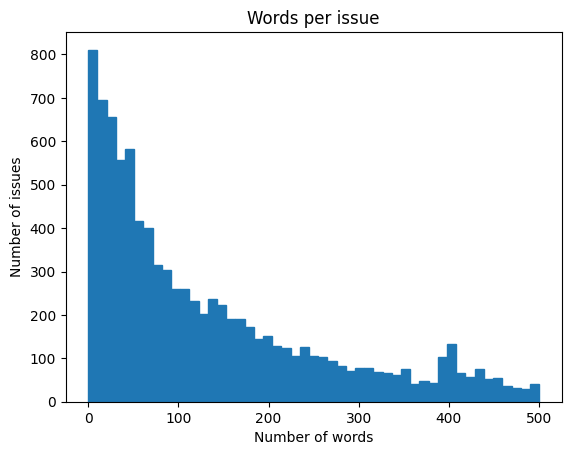

In [17]:
import numpy as np 
import matplotlib.pyplot as plt 
(df_issues["text"].str.split().apply(len) .hist(bins=np.linspace(0, 500, 50), grid=False, edgecolor="C0")) 
plt.title("Words per issue") 
plt.xlabel("Number of words") 
plt.ylabel("Number of issues") 
plt.show()

In [18]:
from sklearn.preprocessing import MultiLabelBinarizer 
mlb = MultiLabelBinarizer() 
mlb.fit([all_labels]) 
mlb.transform([["tokenization", "new model"], ["pytorch"]])

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [21]:
from skmultilearn.model_selection import iterative_train_test_split
import numpy as np
def balanced_split(df, test_size=0.5):
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["labels"])
    ind_train, _, ind_test, _ = iterative_train_test_split(ind, labels, test_size)
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:, 0]]


In [22]:
from sklearn.model_selection import train_test_split 
df_clean = df_issues[["text", "labels", "split"]].reset_index(drop=True).copy() 
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]] 
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]] 

np.random.seed(0) 
df_train, df_tmp = balanced_split(df_sup, test_size=0.5) 
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)

In [23]:
from datasets import Dataset, DatasetDict 
ds = DatasetDict({ "train": Dataset.from_pandas(df_train.reset_index(drop=True)), "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)), "test": Dataset.from_pandas(df_test.reset_index(drop=True)), "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))})

In [24]:
np.random.seed(0) 
all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1) 
indices_pool = all_indices 
labels = mlb.transform(ds["train"]["labels"]) 
train_samples = [8, 16, 32, 64, 128] 
train_slices, last_k = [], 0 
for i, k in enumerate(train_samples):
	# Split off samples necessary to fill the gap to the next split size 
	indices_pool, labels, new_slice, _ = iterative_train_test_split( indices_pool, labels, (k-last_k)/len(labels)) 
	last_k = k 
	if i==0: 
		train_slices.append(new_slice) 
	else: 
		train_slices.append(np.concatenate((train_slices[-1], new_slice))) 
# Add full dataset as last slice 
train_slices.append(all_indices), train_samples.append(len(ds["train"])) 
train_slices = [np.squeeze(train_slice) for train_slice in train_slices]
print("Target split sizes:") 
print(train_samples) 
print("Actual split sizes:") 
print([len(x) for x in train_slices]) 

Target split sizes:
[8, 16, 32, 64, 128, 223]
Actual split sizes:
[10, 19, 36, 68, 134, 223]


In [25]:
def prepare_labels(batch): 
	batch["label_ids"] = mlb.transform(batch["labels"]) 
	return batch 
ds = ds.map(prepare_labels, batched=True)


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [26]:
from collections import defaultdict
macro_scores, micro_scores = defaultdict(list), defaultdict(list)

In [30]:
from sklearn.naive_bayes import MultinomialNB 
from sklearn.metrics import classification_report 
from skmultilearn.problem_transform import BinaryRelevance 
from sklearn.feature_extraction.text import CountVectorizer 

for train_slice in train_slices: 
    # 获取训练片段和测试数据
    ds_train_sample = ds["train"].select(train_slice) 
    y_train = np.array(ds_train_sample["label_ids"]) 
    y_test = np.array(ds["test"]["label_ids"]) 
    # 使用简单的计数向量器编码文本为令牌计数
    count_vect = CountVectorizer() 
    X_train_counts = count_vect.fit_transform(ds_train_sample["text"]) 
    X_test_counts = count_vect.transform(ds["test"]["text"]) 
    # 创建并训练模型
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train) 
    # 生成预测并评估
    y_pred_test = classifier.predict(X_test_counts) 
    clf_report = classification_report(y_test, y_pred_test, target_names=mlb.classes_, zero_division=0, output_dict=True) 
    # 存储指标
    macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"]) 
    micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])


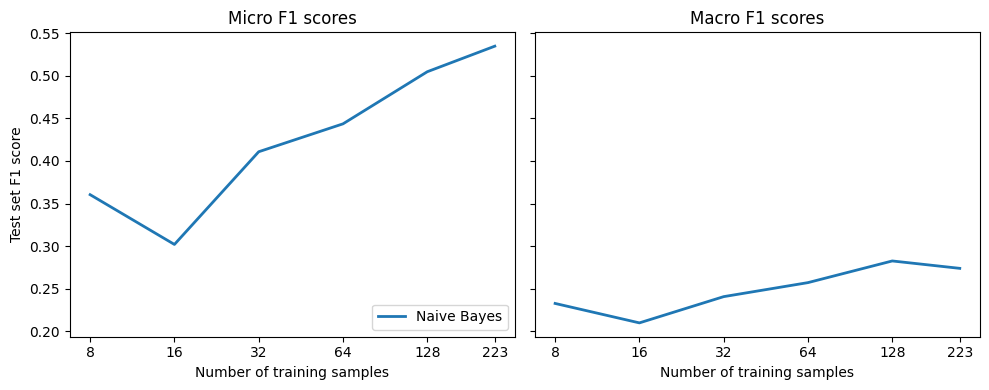

In [31]:
import matplotlib.pyplot as plt 
def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model): 
	fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True) 
	for run in micro_scores.keys(): 
		if run == current_model: 
			ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2) 
			ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2) 
		else: 
			ax0.plot(sample_sizes, micro_scores[run], label=run, linestyle="dashed") 
			ax1.plot(sample_sizes, macro_scores[run], label=run, linestyle="dashed") 
	ax0.set_title("Micro F1 scores") 
	ax1.set_title("Macro F1 scores") 
	ax0.set_ylabel("Test set F1 score") 
	ax0.legend(loc="lower right") 
	for ax in [ax0, ax1]: 
		ax.set_xlabel("Number of training samples") 
		ax.set_xscale("log") 
		ax.set_xticks(sample_sizes) 
		ax.set_xticklabels(sample_sizes) 
		ax.minorticks_off() 
	plt.tight_layout() 
	plt.show() 
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")

In [32]:
from transformers import pipeline 
pipe = pipeline("fill-mask", model="bert-base-uncased")

2024-02-29 10:47:46.217595: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 10:47:46.217725: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 10:47:46.400687: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [33]:
movie_desc = "The main characters of the movie madacascar \ are a lion, a zebra, a giraffe, and a hippo. " 
prompt = "The movie is about [MASK]." 
output = pipe(movie_desc + prompt) 
for element in output: 
	print(f"Token {element['token_str']}:\t{element['score']:.3f}%") 

Token animals:	0.094%
Token lions:	0.064%
Token birds:	0.024%
Token cattle:	0.013%
Token turtles:	0.013%


In [34]:
output = pipe(movie_desc + prompt, targets=["animals", "cars"]) 
for element in output: 
	print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token animals:	0.094%
Token cars:	0.001%


In [35]:
movie_desc = "In the movie transformers aliens \ can morph into a wide range of vehicles." 
output = pipe(movie_desc + prompt, targets=["animals", "cars"]) 
for element in output: 
	print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token cars:	0.063%
Token animals:	0.003%


In [36]:
from transformers import pipeline 
pipe = pipeline("zero-shot-classification", device=0)

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [37]:
sample = ds["train"][0] 
print(f"Labels: {sample['labels']}") 
output = pipe(sample["text"], all_labels, multi_label=True) 
print(output["sequence"][:400]) 
print("\nPredictions:") 
for label, score in zip(output["labels"], output["scores"]): 
	print(f"{label}, {score:.2f}") 

Labels: ['new model']
Add new CANINE model

# 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokeni

Predictions:
new model, 0.98
tensorflow or tf, 0.37
examples, 0.34
usage, 0.30
pytorch, 0.25
documentation, 0.25
model training, 0.24
tokenization, 0.17
pipeline, 0.16


In [38]:
def zero_shot_pipeline(example): 
	output = pipe(example["text"], all_labels, multi_label=True) 
	example["predicted_labels"] = output["labels"] 
	example["scores"] = output["scores"] 
	return example 
ds_zero_shot = ds["valid"].map(zero_shot_pipeline)

  0%|          | 0/106 [00:00<?, ?ex/s]

/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [41]:
def get_preds(example, threshold=None, topk=None):
    preds = []
    if threshold:
        for label, score in zip(example["predicted_labels"], example["scores"]):
            if score >= threshold:
                preds.append(label)
    elif topk:
        for i in range(topk):
            preds.append(example["predicted_labels"][i])
    else:
        raise ValueError("Set either `threshold` or `topk`.")
    return {"pred_label_ids": list(np.squeeze(mlb.transform([preds])))}


In [42]:
def get_clf_report(ds): 
	y_true = np.array(ds["label_ids"]) 
	y_pred = np.array(ds["pred_label_ids"]) 
	return classification_report( y_true, y_pred, target_names=mlb.classes_, zero_division=0, output_dict=True)

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

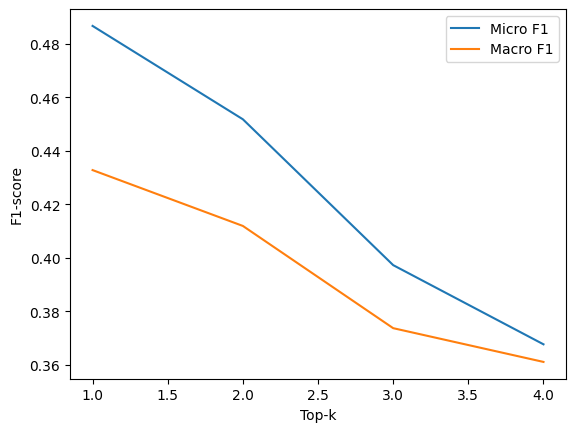

In [43]:
macros, micros = [], [] 
topks = [1, 2, 3, 4] 
for topk in topks: 
	ds_zero_shot = ds_zero_shot.map(get_preds, batched=False, fn_kwargs={'topk': topk}) 
	clf_report = get_clf_report(ds_zero_shot) 
	micros.append(clf_report['micro avg']['f1-score']) 
	macros.append(clf_report['macro avg']['f1-score']) 
plt.plot(topks, micros, label='Micro F1') 
plt.plot(topks, macros, label='Macro F1') 
plt.xlabel("Top-k") 
plt.ylabel("F1-score") 
plt.legend(loc='best') 
plt.show()

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

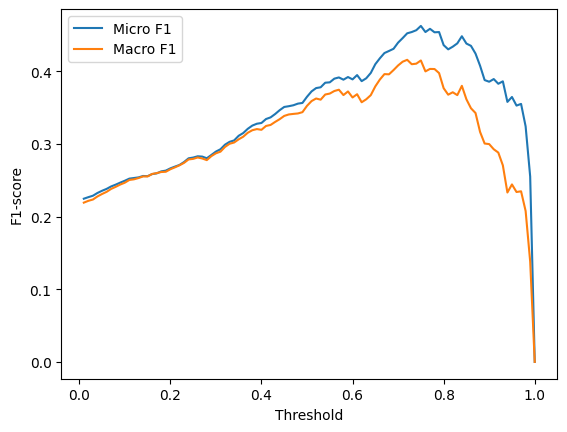

In [46]:
macros, micros = [], []
thresholds = np.linspace(0.01, 1, 100)
for threshold in thresholds:
    ds_zero_shot = ds_zero_shot.map(get_preds, fn_kwargs={"threshold": threshold})
    clf_report = get_clf_report(ds_zero_shot)
    micros.append(clf_report["micro avg"]["f1-score"])
    macros.append(clf_report["macro avg"]["f1-score"])
plt.plot(thresholds, micros, label="Micro F1")
plt.plot(thresholds, macros, label="Macro F1")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.legend(loc="best")
plt.show()


In [48]:
best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros) 
print(f'Best threshold (micro): {best_t} with F1-score {best_micro:.2f}.') 
best_t, best_macro = thresholds[np.argmax(macros)], np.max(macros) 
print(f'Best threshold (micro): {best_t} with F1-score {best_macro:.2f}.')

Best threshold (micro): 0.75 with F1-score 0.46.
Best threshold (micro): 0.72 with F1-score 0.42.


  0%|          | 0/111 [00:00<?, ?ex/s]

/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


  0%|          | 0/111 [00:00<?, ?ex/s]

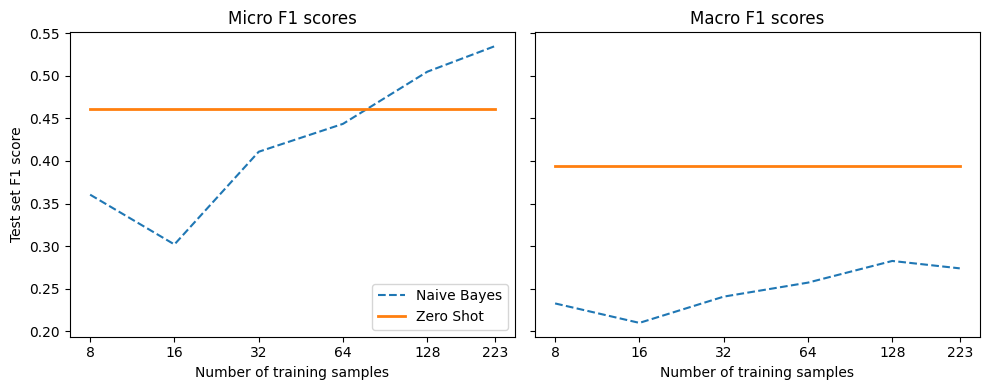

In [49]:
ds_zero_shot = ds['test'].map(zero_shot_pipeline) 
ds_zero_shot = ds_zero_shot.map(get_preds, fn_kwargs={'topk': 1})
clf_report = get_clf_report(ds_zero_shot) 
for train_slice in train_slices: 
	macro_scores['Zero Shot'].append(clf_report['macro avg']['f1-score']) 
	micro_scores['Zero Shot'].append(clf_report['micro avg']['f1-score']) 
plot_metrics(micro_scores, macro_scores, train_samples, "Zero Shot")

In [51]:
!pip install nlpaug
from transformers import set_seed 
import nlpaug.augmenter.word as naw
set_seed(3) 
aug = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", device="cpu", action="substitute") 
text = "Transformers are the most popular toys" 
print(f"Original text: {text}") 
print(f"Augmented text: {aug.augment(text)}") 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 3.2 MB/s eta 0:00:00a 0:00:01m


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Original text: Transformers are the most popular toys
Augmented text: ['transformers get the most interesting toys']


In [54]:
def augment_text(batch, transformations_per_example=1): 
    text_aug, label_ids = [], [] 
    for text, labels in zip(batch["text"], batch["label_ids"]): 
        text_aug += [text] 
        label_ids += [labels] 
        for _ in range(transformations_per_example): 
            text_aug += [aug.augment(text)] 
            label_ids += [labels]
    return {"text": text_aug, "label_ids": label_ids}


In [ ]:
ds_train_sample = ds_train_sample.map(augment_text, batched=True, remove_columns=ds_train_sample.column_names).shuffle(seed=42)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes + Aug")

In [ ]:
import torch 
from transformers import AutoTokenizer, AutoModel 
model_ckpt = "miguelvictor/python-gpt2-large" 
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt) 
def mean_pooling(model_output, attention_mask): 
	# Extract the token embeddings 
	token_embeddings = model_output[0] 
	# Compute the attention mask 
	input_mask_expanded = (attention_mask .unsqueeze(-1) .expand(token_embeddings.size()) .float()) 
	# Sum the embeddings, but ignore masked tokens 
	sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1) 
	sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9) 
	# Return the average as a single vector 
	return sum_embeddings / sum_mask 
def embed_text(examples): 
	inputs = tokenizer(examples["text"], padding=True, truncation=True, max_length=128, return_tensors="pt") 
	with torch.no_grad():
		model_output = model(**inputs) 
	pooled_embeds = mean_pooling(model_output, inputs["attention_mask"]) 
	return {"embedding": pooled_embeds.cpu().numpy()}

In [ ]:
tokenizer.pad_token = tokenizer.eos_token 
embs_train = ds["train"].map(embed_text, batched=True, batch_size=16) 
embs_valid = ds["valid"].map(embed_text, batched=True, batch_size=16) 
embs_test = ds["test"].map(embed_text, batched=True, batch_size=16)

In [ ]:
embs_train.add_faiss_index("embedding")

In [ ]:
i, k = 0, 3
# Select the first query and 3 nearest neighbors 
rn, nl = "\r\n\r\n", "\n"
# Used to remove newlines in text for compact display 
query = np.array(embs_valid[i]["embedding"], dtype=np.float32) 
scores, samples = embs_train.get_nearest_examples("embedding", query, k=k) 
print(f"QUERY LABELS: {embs_valid[i]['labels']}") 
print(f"QUERY TEXT:\n{embs_valid[i]['text'][:200].replace(rn, nl)} [...]\n") 
print("="*50) 
print(f"Retrieved documents:") 
for score, label, text in zip(scores, samples["labels"], samples["text"]): 
	print("="*50) 
	print(f"TEXT:\n{text[:200].replace(rn, nl)} [...]") 
	print(f"SCORE: {score:.2f}") 
	print(f"LABELS: {label}") 

In [ ]:
def get_sample_preds(sample, m): 
	return (np.sum(sample["label_ids"], axis=0) >= m).astype(int) 
def find_best_k_m(ds_train, valid_queries, valid_labels, max_k=17):
	max_k = min(len(ds_train), max_k) 
	perf_micro = np.zeros((max_k, max_k)) 
	perf_macro = np.zeros((max_k, max_k)) 
	for k in range(1, max_k): 
		for m in range(1, k + 1):
        	_, samples = ds_train.get_nearest_examples_batch("embedding", valid_queries, k=k) 
        	y_pred = np.array([get_sample_preds(s, m) for s in samples]) 
        	clf_report = classification_report(valid_labels, y_pred
target_names=mlb.classes_, zero_division=0, output_dict=True) 
			perf_micro[k, m] = clf_report["micro avg"]["f1-score"] 
			perf_macro[k, m] = clf_report["macro avg"]["f1-score"] 
	return perf_micro, perf_macro

In [ ]:
valid_labels = np.array(embs_valid["label_ids"]) 
valid_queries = np.array(embs_valid["embedding"], dtype=np.float32) 
perf_micro, perf_macro = find_best_k_m(embs_train, valid_queries, valid_labels) 
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True) 
ax0.imshow(perf_micro)
ax1.imshow(perf_macro) 
ax0.set_title("micro scores")
ax0.set_ylabel("k") 
ax1.set_title("macro scores") 
for ax in [ax0, ax1]: 
	ax.set_xlim([0.5, 17 - 0.5]) 
	ax.set_ylim([17 - 0.5, 0.5]) 
	ax.set_xlabel("m") 
plt.show()

In [ ]:
k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape) 
print(f"Best k: {k}, best m: {m}")

In [ ]:
embs_train.drop_index("embedding") 
test_labels = np.array(embs_test["label_ids"]) 
test_queries = np.array(embs_test["embedding"], dtype=np.float32) 
for train_slice in train_slices: 
# Create a Faiss index from training slice 
	embs_train_tmp = embs_train.select(train_slice) 	
	embs_train_tmp.add_faiss_index("embedding")
    # Get best k, m values with validation set 
    perf_micro, _ = find_best_k_m(embs_train_tmp, valid_queries, valid_labels) 
    k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape) 
    # Get predictions on test set 
    _, samples = embs_train_tmp.get_nearest_examples_batch("embedding", test_queries, k=int(k)) 
    y_pred = np.array([get_sample_preds(s, m) for s in samples]) 
    # Evaluate predictions 
    clf_report = classification_report(test_labels, y_pred, target_names=mlb.classes_, zero_division=0, output_dict=True,) 
    macro_scores["Embedding"].append(clf_report["macro avg"]["f1-score"]) 
    micro_scores["Embedding"].append(clf_report["micro avg"]["f1-score"]
    
plot_metrics(micro_scores, macro_scores, train_samples, "Embedding")


In [ ]:
import torch 
from transformers import (AutoTokenizer, AutoConfig, AutoModelForSequenceClassification) 

model_ckpt = "bert-base-uncased" 
tokenizer = AutoTokenizer.from_pretrained(model_ckpt) 
def tokenize(batch): 
	return tokenizer(batch["text"], truncation=True, max_length=128) 
ds_enc = ds.map(tokenize, batched=True) 
ds_enc = ds_enc.remove_columns(['labels', 'text'])


In [ ]:
ds_enc.set_format("torch") 
ds_enc = ds_enc.map(lambda x: {"label_ids_f": x["label_ids"].to(torch.float)}, remove_columns=["label_ids"]) 
ds_enc = ds_enc.rename_column("label_ids_f", "label_ids")


In [ ]:
from transformers import Trainer, TrainingArguments 
training_args_fine_tune = TrainingArguments( output_dir="./results", num_train_epochs=20, learning_rate=3e-5, lr_scheduler_type='constant', per_device_train_batch_size=4, per_device_eval_batch_size=32, weight_decay=0.0, evaluation_strategy="epoch", save_strategy="epoch",logging_strategy="epoch", load_best_model_at_end=True, metric_for_best_model='micro f1', save_total_limit=1, log_level='error')


In [ ]:
from scipy.special import expit as sigmoid 
def compute_metrics(pred): 
	y_true = pred.label_ids
    y_pred = sigmoid(pred.predictions) 
    y_pred = (y_pred>0.5).astype(float) 
    clf_dict = classification_report(y_true, y_pred, target_names=all_labels, zero_division=0, output_dict=True) 
    return {"micro f1": clf_dict["micro avg"]["f1-score"], "macro f1": clf_dict["macro avg"]["f1-score"]}


In [ ]:
config = AutoConfig.from_pretrained(model_ckpt) 
config.num_labels = len(all_labels) 
config.problem_type = "multi_label_classification" 
for train_slice in train_slices: 
	model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config) 
	trainer = Trainer( model=model, tokenizer=tokenizer, args=training_args_fine_tune, compute_metrics=compute_metrics, train_dataset=ds_enc["train"].select(train_slice), eval_dataset=ds_enc["valid"],) 
	trainer.train() 
	pred = trainer.predict(ds_enc["test"]) 
	metrics = compute_metrics(pred) 
	macro_scores["Fine-tune (vanilla)"].append(metrics["macro f1"]) 
	micro_scores["Fine-tune (vanilla)"].append(metrics["micro f1"]) 

plot_metrics(micro_scores, macro_scores, train_samples, "Fine-tune (vanilla)")


In [ ]:
prompt = """\ Translate English to French: thanks => """


In [ ]:
def tokenize(batch):
	return tokenizer(batch["text"], truncation=True, max_length=128, return_special_tokens_mask=True) 
	ds_mlm = ds.map(tokenize, batched=True) 
	ds_mlm = ds_mlm.remove_columns(["labels", "text", "label_ids"])


In [ ]:
from transformers import DataCollatorForLanguageModeling, set_seed 
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)


In [ ]:
set_seed(3) 
data_collator.return_tensors = "np" 
inputs = tokenizer("Transformers are awesome!", return_tensors="np") 
outputs = data_collator([{"input_ids": inputs["input_ids"][0]}])

pd.DataFrame({ "Original tokens": tokenizer.convert_ids_to_tokens(inputs["input_ids"] [0]), "Masked tokens": tokenizer.convert_ids_to_tokens(outputs["input_ids"][0]), "Original input_ids": original_input_ids, "Masked input_ids": masked_input_ids, "Labels": outputs["labels"][0]}).T


In [ ]:
data_collator.return_tensors = "pt"


In [ ]:
from transformers import AutoModelForMaskedLM 

training_args = TrainingArguments( output_dir = f"{model_ckpt}-issues-128", per_device_train_batch_size=32, logging_strategy="epoch", evaluation_strategy="epoch", save_strategy="no", num_train_epochs=16, push_to_hub=True, log_level="error", report_to="none") 

trainer = Trainer( model=AutoModelForMaskedLM.from_pretrained("bert-base-uncased"), tokenizer=tokenizer, args=training_args, data_collator=data_collator, train_dataset=ds_mlm["unsup"], eval_dataset=ds_mlm["train"]) 

trainer.train() 
trainer.push_to_hub("Training complete!")


In [ ]:
df_log = pd.DataFrame(trainer.state.log_history) 

(df_log.dropna(subset=["eval_loss"]).reset_index()["eval_loss"] .plot(label="Validation")) 

df_log.dropna(subset=["loss"]).reset_index()["loss"].plot(label="Train")
plt.xlabel("Epochs") 
plt.ylabel("Loss") 
plt.legend(loc="upper right")
plt.show()


# 第10章 从头训练 Transformers 模型

In [ ]:
from transformers import pipeline, set_seed 
generation_gpt = pipeline("text-generation", model="openai-gpt") 
generation_gpt2 = pipeline("text-generation", model="gpt2")


In [ ]:
def model_size(model): 
	return sum(t.numel() for t in model.parameters()) 
	
print(f"GPT size: {model_size(generation_gpt.model)/1000**2:.1f}M parameters") 

print(f"GPT2 size: {model_size(generation_gpt2.model)/1000**2:.1f}M parameters") 

In [ ]:
def enum_pipeline_ouputs(pipe, prompt, num_return_sequences): 
	out = pipe(prompt, num_return_sequences=num_return_sequences, clean_up_tokenization_spaces=True) 
	return "\n".join(f"{i+1}." + s["generated_text"] for i, s in enumerate(out)) 
prompt = "\nWhen they came back" 
print("GPT completions:\n" + enum_pipeline_ouputs(generation_gpt, prompt, 3)) 
print("") print("GPT-2 completions:\n" + enum_pipeline_ouputs(generation_gpt2, prompt, 3)) 

In [ ]:
SELECT 
f.repo_name, f.path, c.copies, c.size, c.content, l.license 
FROM `bigquery-public-data.github_repos.files` AS f 
JOIN `bigquery-public-data.github_repos.contents` AS c ON f.id = c.id 
JOIN `bigquery-public-data.github_repos.licenses` AS l ON f.repo_name = l.repo_name 
WHERE NOT c.binary
AND ((f.path LIKE '%.py') 
AND (c.size BETWEEN 1024 AND 1048575))

In [ ]:
$ gsutil -m -o "GSUtil:parallel_process_count=1" 
cp -r gs://<name_of_bucket>

In [ ]:
$ git clone https://huggingface.co/datasets/transformersbook/codeparrot


In [ ]:
from datasets import load_dataset, DownloadConfig 
download_config = DownloadConfig(delete_extracted=True)

dataset = load_dataset("./codeparrot", split="train", download_config=download_config)


In [ ]:
import psutil
print(f"Number of python files code in dataset : {len(dataset)}") 
ds_size = sum(os.stat(f["filename"]).st_size for f in dataset.cache_files)
# os.stat.st_size is expressed in bytes, so we convert to GB 
print(f"Dataset size (cache file) : {ds_size / 2**30:.2f} GB") 
# Process.memory_info is expressed in bytes, so we convert to MB 
print(f"RAM used: {psutil.Process(os.getpid()).memory_info().rss >> 20} MB") 

In [ ]:
streamed_dataset = load_dataset('./codeparrot', split="train", streaming=True)


In [ ]:
iterator = iter(streamed_dataset) 
print(dataset[0] == next(iterator)) 
print(dataset[1] == next(iterator)) 

In [ ]:
remote_dataset = load_dataset('transformersbook/codeparrot', split="train", streaming=True)


In [ ]:
$ huggingface-cli login

In [ ]:
$ huggingface-cli repo create --type dataset --organization transformersbook \ codeparrot-train 
$ huggingface-cli repo create --type dataset --organization transformersbook \ codeparrot-valid

In [ ]:
from transformers import AutoTokenizer 
def tok_list(tokenizer, string):
	input_ids = tokenizer(string, add_special_tokens=False)["input_ids"] 
	return [tokenizer.decode(tok) for tok in input_ids] 
tokenizer_T5 = AutoTokenizer.from_pretrained("t5-base") 
tokenizer_camembert = AutoTokenizer.from_pretrained("camembert-base") 
print(f'T5 tokens for "sex": {tok_list(tokenizer_T5,"sex")}')
print(f'CamemBERT tokens for "being": {tok_list(tokenizer_camembert,"being")}') 

In [ ]:
from transformers import AutoTokenizer 
python_code = r"""
def say_hello(): 
	print("Hello, World!") 
# Print it say_hello() """ 
tokenizer = AutoTokenizer.from_pretrained("gpt2") 
print(tokenizer(python_code).tokens()) 

In [ ]:
print(tokenizer.backend_tokenizer.normalizer)

In [ ]:
print(tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(python_code))

In [ ]:
a, e = u"a", u"€"
byte = ord(a.encode("utf-8"))
print(f'`{a}` is encoded as `{a.encode("utf-8")}` with a single byte: {byte}')
byte = [ord(chr(i)) for i in e.encode("utf-8")] 
print(f'`{e}` is encoded as `{e.encode("utf-8")}` with three bytes: {byte}') 

In [ ]:
from transformers.models.gpt2.tokenization_gpt2 
import bytes_to_unicode 
byte_to_unicode_map = bytes_to_unicode() 
unicode_to_byte_map = dict((v, k) for k, v in byte_to_unicode_map.items()) 
base_vocab = list(unicode_to_byte_map.keys()) 
print(f'Size of our base vocabulary: {len(base_vocab)}') 
print(f'First element: `{base_vocab[0]}`, last element: `{base_vocab[-1]}`') 

In [ ]:
print(tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(python_code))

In [ ]:
print(f"Size of the vocabulary: {len(tokenizer)}") 

In [ ]:
tokens = sorted(tokenizer.vocab.items(), key=lambda x: len(x[0]), reverse=True)
print([f'{tokenizer.convert_tokens_to_string(t)}' for t, _ in tokens[:8]])

In [ ]:
tokens = sorted(tokenizer.vocab.items(), key=lambda x: x[1], reverse=True) 
print([f'{tokenizer.convert_tokens_to_string(t)}' for t, _ in tokens[:12]])

In [ ]:
from tqdm.auto import tqdm 
length = 10000
dataset_name = 'transformersbook/codeparrot-train' 
dataset = load_dataset(dataset_name, split="train", streaming=True) 
iter_dataset = iter(dataset) 
def batch_iterator(batch_size=10): 
	for _ in tqdm(range(0, length, batch_size)): 
		yield [next(iter_dataset)['content'] for _ in range(batch_size)] 

new_tokenizer = tokenizer.train_new_from_iterator(batch_iterator(), vocab_size=12500, initial_alphabet=base_vocab)


In [ ]:
tokens = sorted(new_tokenizer.vocab.items(), key=lambda x: x[1], reverse=False) 

print([f'{tokenizer.convert_tokens_to_string(t)}' for t, _ in tokens[257:280]])

In [ ]:
print([f'{new_tokenizer.convert_tokens_to_string(t)}' for t,_ in tokens[-12:]])

In [ ]:
print(new_tokenizer(python_code).tokens()) 

In [ ]:
import keyword print(f'There are in total {len(keyword.kwlist)} Python keywords.') 
for keyw in keyword.kwlist: 
	if keyw not in new_tokenizer.vocab: 
		print(f'No, keyword `{keyw}` is not in the vocabulary') 

In [ ]:
length = 200000 
new_tokenizer_larger = tokenizer.train_new_from_iterator(batch_iterator(), vocab_size=32768, initial_alphabet=base_vocab)


In [ ]:
tokens = sorted(new_tokenizer_larger.vocab.items(), key=lambda x: x[1], reverse=False) 
print([f'{tokenizer.convert_tokens_to_string(t)}' for t, _ in tokens[-12:]])

In [ ]:
print(new_tokenizer_larger(python_code).tokens()) 

In [ ]:
for keyw in keyword.kwlist: 
	if keyw not in new_tokenizer_larger.vocab:
    	print(f'No, keyword `{keyw}` is not in the vocabulary')

In [ ]:
model_ckpt = "codeparrot"
org = "transformersbook" new_tokenizer_larger.push_to_hub(model_ckpt, organization=org)


In [ ]:
reloaded_tokenizer = AutoTokenizer.from_pretrained(org + "/" + model_ckpt) 

print(reloaded_tokenizer(python_code).tokens())

In [ ]:
new_tokenizer.push_to_hub(model_ckpt+ "-small-vocabulary", organization=org)


In [ ]:
rom transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer 
tokenizer = AutoTokenizer.from_pretrained(model_ckpt) 
config = AutoConfig.from_pretrained("gpt2-xl", vocab_size=len(tokenizer))
model = AutoModelForCausalLM.from_config(config)


In [ ]:
print(f'GPT-2 (xl) size: {model_size(model)/1000**2:.1f}M parameters')
GPT-2 (xl) size: 1529.6M parameters


In [ ]:
model.save_pretrained("models/" + model_ckpt, push_to_hub=True, organization=org)


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt) 
config_small = AutoConfig.from_pretrained("gpt2", vocab_size=len(tokenizer)) 
model_small = AutoModelForCausalLM.from_config(config_small) 
print(f'GPT-2 size: {model_size(model_small)/1000**2:.1f}M parameters')

In [ ]:
model_small.save_pretrained("models/" + model_ckpt + "-small", push_to_hub=True, organization=org)


In [ ]:
examples, total_characters, total_tokens = 500, 0, 0 
dataset = load_dataset('transformersbook/codeparrot-train', split='train', streaming=True) 
for _, example in tqdm(zip(range(examples), iter(dataset)), total=examples): 
	total_characters += len(example['content']) 
	total_tokens += len(tokenizer(example['content']).tokens())
characters_per_token = total_characters / total_tokens print(characters_per_token) 3.6233025034779565


In [ ]:
shuffled_dataset = dataset.shuffle(buffer_size=100)
constant_length_dataset = ConstantLengthDataset(tokenizer, shuffled_dataset, num_of_sequences=10) 
dataset_iterator = iter(constant_length_dataset) 
lengths = [len(b) for _, b in zip(range(5), dataset_iterator)]
print(f"Lengths of the sequences: {lengths}") 
Fill buffer: 0<36864 
Fill buffer: 3311<36864 
Fill buffer: 9590<36864 
Fill buffer: 22177<36864
Fill buffer: 25530<36864
Fill buffer: 31098<36864 
Fill buffer: 32232<36864 
Fill buffer: 33867<36864 
Buffer full: 41172>=36864 Lengths of the sequences: [1024, 1024, 1024, 1024, 1024]

In [ ]:
from argparse import Namespace 
# Commented parameters correspond to the small model 
config = {"train_batch_size": 2, # 12 
        "valid_batch_size": 2, # 12 
        "weight_decay": 0.1, "shuffle_buffer": 1000, "learning_rate": 2e-4, # 5e-4
        "lr_scheduler_type": "cosine", "num_warmup_steps": 750, # 2000 
        "gradient_accumulation_steps": 16, # 1 "max_train_steps": 50000, # 150000 
        "max_eval_steps": -1, "seq_length": 1024, "seed": 1, "save_checkpoint_steps": 50000} # 15000 
args = Namespace(**config)


In [ ]:
def log_metrics(step, metrics): 
	logger.info(f"Step {step}: {metrics}"
	if accelerator.is_main_process: 
		wandb.log(metrics) [tb_writer.add_scalar(k, v, step) for k, v in metrics.items()]


In [ ]:
$ git clone https://huggingface.co/transformersbook/codeparrot 
$ cd codeparrot 
$ pip install -r requirements.txt 
$ wandb login
$ accelerate config
$ accelerate launch codeparrot_training.py


In [ ]:
$ git checkout main 
$ git merge <RUN_NAME> 
$ git push


In [ ]:
prompt = '''X = np.random.randn(100, 100) 
y = np.random.randint(0, 1, 100) 
# fit random forest classifier with 20 estimators''' 
complete_code(generation, prompt, max_length=96) 
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation. reg = DummyRegressor() forest = RandomForestClassifier(n_estimators=20) 
forest.fit(X, y) ============================================================================== == 
clf = ExtraTreesClassifier(n_estimators=100, max_features='sqrt')
clf.fit(X, y) ============================================================================== == 
clf = RandomForestClassifier(n_estimators=20, n_jobs=n_jobs, random_state=1) 
clf.fit(X, y) ============================================================================== =
clf = RandomForestClassifier(n_estimators=20) 
clf.fit(X, y)
